In [1]:
!pip install networkx node2vec scikit-learn torch torch-geometric matplotlib tqdm



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import networkx as nx
import numpy as np
import torch
from torch_geometric.datasets import Planetoid
from node2vec import Node2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random


In [3]:
from torch_geometric.utils import to_networkx

dataset = Planetoid(root="D:\cora\cora", name='Cora')
data = dataset[0]
G = to_networkx(data, to_undirected=True)
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")


Nodes: 2708, Edges: 5278


In [4]:
edges = list(G.edges())
random.shuffle(edges)
split_idx = int(0.8 * len(edges))
train_edges = edges[:split_idx]
test_edges_pos = edges[split_idx:]

# Build train graph
G_train = nx.Graph()
G_train.add_nodes_from(G.nodes())
G_train.add_edges_from(train_edges)

def sample_negative_edges(G, num_samples):
    nodes = list(G.nodes())
    negatives = set()
    while len(negatives) < num_samples:
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v):
            negatives.add((u, v))
    return list(negatives)

test_edges_neg = sample_negative_edges(G, len(test_edges_pos))


In [5]:
# Learn node embeddings
node2vec = Node2Vec(G_train, dimensions=128, walk_length=20, num_walks=100, workers=2)
model_n2v = node2vec.fit(window=10, min_count=1)

def get_edge_feature(u, v):
    return model_n2v.wv[str(u)] * model_n2v.wv[str(v)]   # Hadamard product

# Training data (positive + negative edges from training graph)
train_neg = sample_negative_edges(G_train, len(train_edges))
X_train, y_train = [], []

for u,v in train_edges:
    X_train.append(get_edge_feature(u,v))
    y_train.append(1)
for u,v in train_neg:
    X_train.append(get_edge_feature(u,v))
    y_train.append(0)

# Testing data
X_test, y_test = [], []
for u,v in test_edges_pos:
    X_test.append(get_edge_feature(u,v))
    y_test.append(1)
for u,v in test_edges_neg:
    X_test.append(get_edge_feature(u,v))
    y_test.append(0)

# Train classifier
clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)

# Predict
y_pred_proba = clf.predict_proba(X_test)[:,1]

auc = roc_auc_score(y_test, y_pred_proba)
ap = average_precision_score(y_test, y_pred_proba)

print(f"AUC: {auc:.4f}")
print(f"Average Precision: {ap:.4f}")


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

AUC: 0.8442
Average Precision: 0.8783


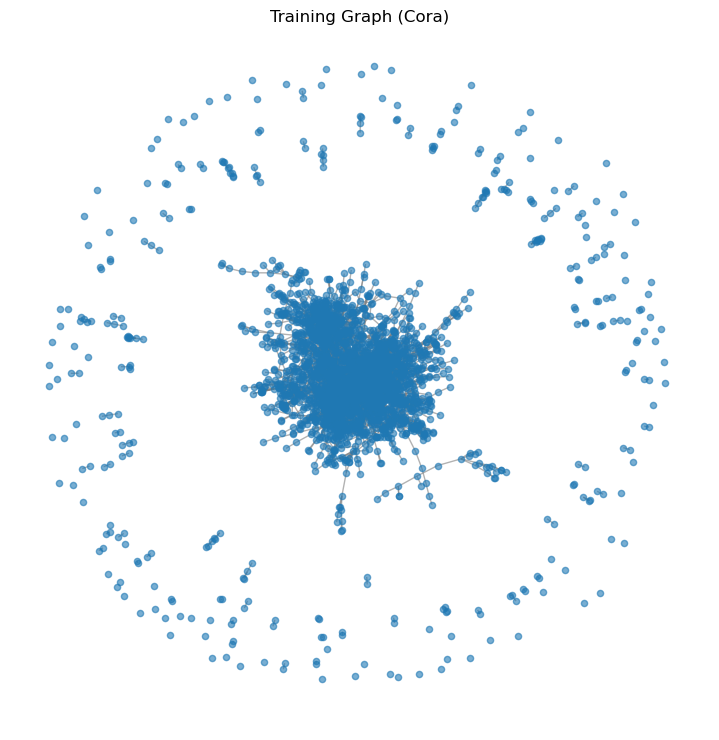

In [6]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G_train, seed=42)
plt.figure(figsize=(7,7))
nx.draw(G_train, pos, node_size=20, alpha=0.6, edge_color='gray')
plt.title("Training Graph (Cora)")
plt.show()


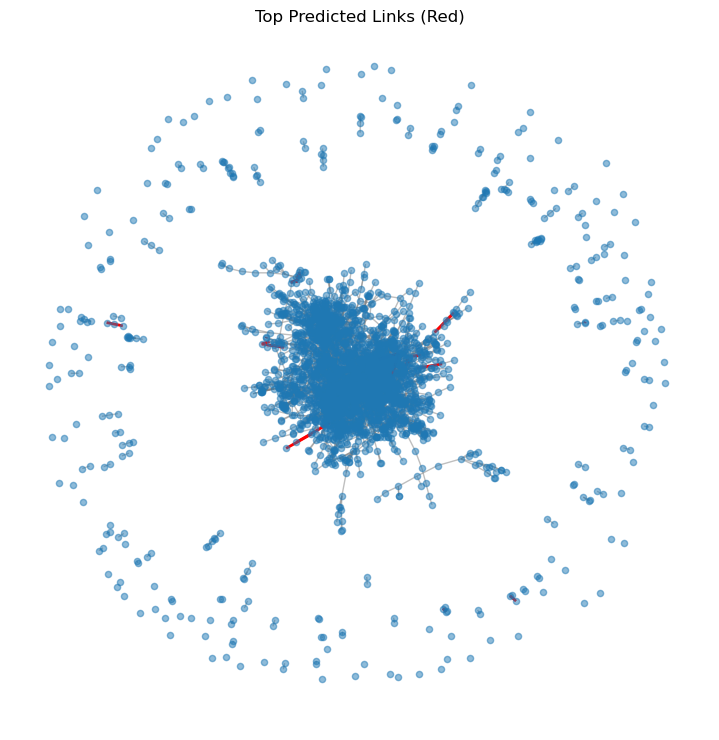

In [7]:
#visualize predicted new links
# Top 20 predicted future links
pred_scores = list(zip(test_edges_pos + test_edges_neg, y_pred_proba))
pred_scores.sort(key=lambda x: x[1], reverse=True)
top_edges = [edge for edge, score in pred_scores[:20]]

plt.figure(figsize=(7,7))
nx.draw(G_train, pos, node_size=20, alpha=0.5, edge_color='gray')
nx.draw_networkx_edges(G_train, pos, edgelist=top_edges, edge_color='r', width=2)
plt.title("Top Predicted Links (Red)")
plt.show()


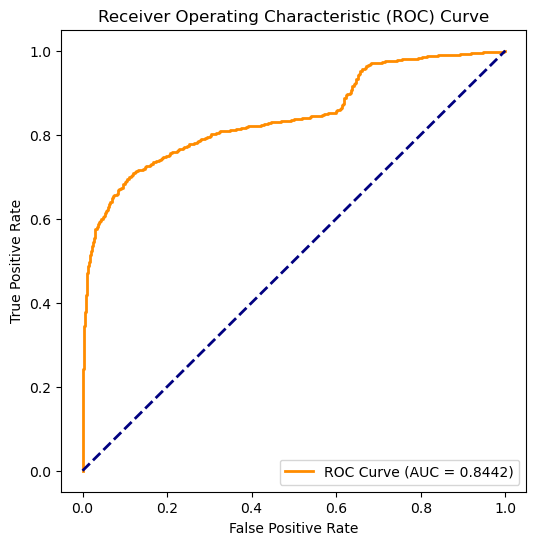

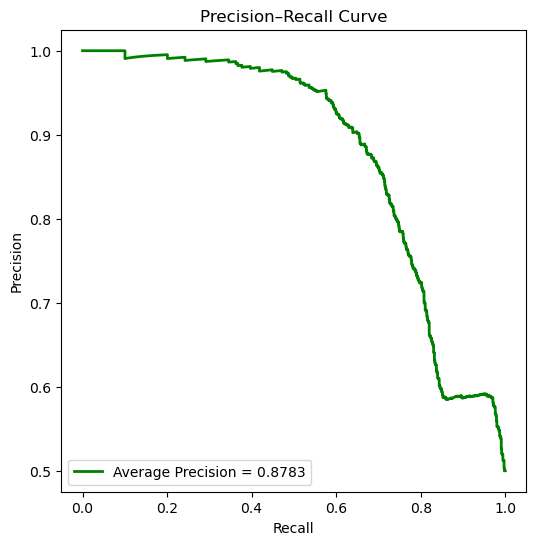

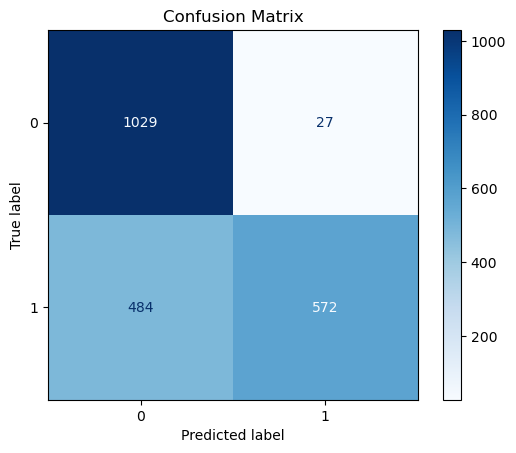

In [8]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

# 1️⃣ ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 2️⃣ Precision–Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='green', lw=2, label=f"Average Precision = {ap:.4f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc="lower left")
plt.show()

# 3️⃣ Confusion Matrix (optional thresholded predictions)
y_pred_class = (y_pred_proba >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [10]:
import networkx as nx

# Get the largest connected component
largest_cc = max(nx.connected_components(G_train), key=len)
G_lcc = G_train.subgraph(largest_cc).copy()

# Compute metrics safely
avg_path_length = nx.average_shortest_path_length(G_lcc)
avg_clustering = nx.average_clustering(G_lcc)

print(f"Average Collaboration Time (path length): {avg_path_length:.4f}")
print(f"Average Collaboration Intensity (clustering): {avg_clustering:.4f}")


Average Collaboration Time (path length): 6.9600
Average Collaboration Intensity (clustering): 0.1823
